## Installs and imports

In [ ]:
!pip install open_flamingo

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 82.4 

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (27 kB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_nvrtc_cu11-11.8.89-py3-none-manylinux1_x86_64.whl (23.2 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_runtime_cu11-11.8.89-py3-none-manylinux1_x86_64.whl (875 kB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cuda_cupti_cu11-11.8.87-py3-none-manylinux1_x86_64.whl (13.1 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cudnn_cu11-9.1.0.70-py3-none-manylinux2014_x86_64.whl (663.9 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cublas_cu11-11.11.3.6-py3-none-manylinux1_x86_64.whl (417.9 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_curand_cu11-10.3.0.86-py3-none-manylinux1_x86_64.whl (58.1 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cusolv

In [ ]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.


In [ ]:
import torch
from open_flamingo import create_model_and_transforms
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
from pycocoevalcap.cider.cider import Cider


#### Helper Functions

In [ ]:

def load_flamingo_model():
    model, image_processor, tokenizer = create_model_and_transforms(
        clip_vision_encoder_path="ViT-L-14",
        clip_vision_encoder_pretrained="openai",
        lang_encoder_path="anas-awadalla/mpt-1b-redpajama-200b",
        tokenizer_path="anas-awadalla/mpt-1b-redpajama-200b",
        cross_attn_every_n_layers=1
    )
    model.eval()
    return model, image_processor, tokenizer

def construct_prompt(text_examples):
    prompt = "".join([f"<image>{caption}<|endofchunk|>" for caption in text_examples])+"<image>An image of"
    return prompt

def cider_score(predicted_caption, target_captions):
    cider = Cider()
    hypo = {0: [predicted_caption]}
    refs = {0: target_captions}
    score, _ = cider.compute_score(refs, hypo)
    return score


def visualize_examples(images, targets, generated):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for idx, img in enumerate(images):
        axes[idx].imshow(img)
        axes[idx].axis("off")
    plt.suptitle(f"Generated: {generated}\nTarget: {targets}")
    plt.show()





## Model Loading

This 3B-parameter model uses a CLIP ViT-L/14 vision encoder and MPT-1B language model.

In [ ]:
model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path="anas-awadalla/mpt-1b-redpajama-200b",
    tokenizer_path="anas-awadalla/mpt-1b-redpajama-200b",
    cross_attn_every_n_layers=1
)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/5.25G [00:00<?, ?B/s]

You are using config.init_device='cpu', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.


model.safetensors:   0%|          | 0.00/5.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/91.0 [00:00<?, ?B/s]

Flamingo model initialized with 1046992944 trainable parameters


Flamingo(
  (vision_encoder): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-23): 24 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-0

In [ ]:
# Check if GPU is available and set device accordingly
device = torch.device("cpu")

# Move the model to the GPU (if available)
model = model.to(device)

## Data Loading

In [ ]:
import os
import pandas
from matplotlib.pyplot import imshow
captions = pandas.read_csv('/content/Flickr8k.token.txt', sep = '\t', header=None)

examples = {'images':[], 'captions':[]}
for file in os.listdir('/content/Flickr_images'):
    image = Image.open(os.path.join('/content/Flickr_images', file)).convert("RGB")
    examples['images'].append(image)
    examples['captions'].append(captions[captions[0]==file+'#0'][1].values[0])

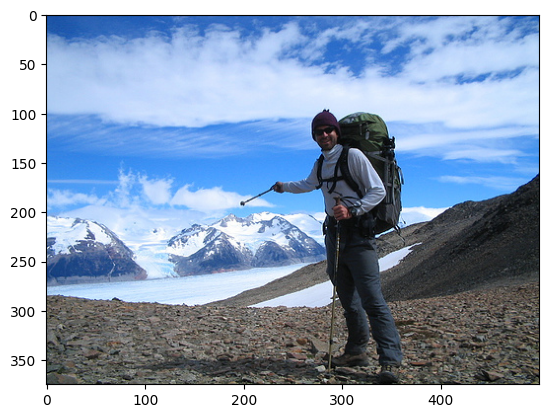

In [ ]:
imshow(examples['images'][0])

In [ ]:
examples['captions'][0]

'A backpacker in the mountains using his hiking stick to point at a glacier .'

### One-shot example

#### Example 1

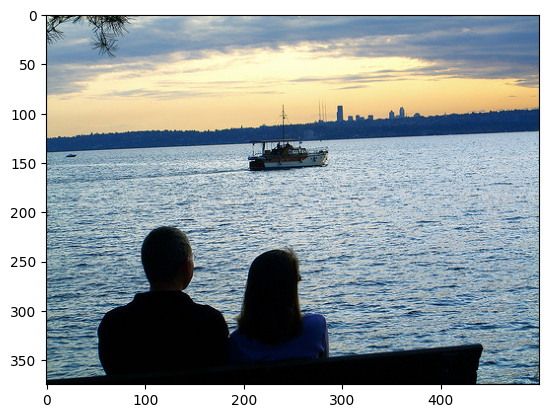

In [ ]:
imshow(examples['images'][1])

In [ ]:
examples['captions'][1]

'A couple watches a boat against a skyline .'

In [ ]:
vision_x = [image_processor(examples['images'][0]).unsqueeze(0), image_processor(examples['images'][1]).unsqueeze(0)]
vision_x = torch.cat(vision_x, dim=0)
vision_x = vision_x.unsqueeze(1).unsqueeze(0)

tokenizer.padding_side = "left" # For generation padding tokens should be on the left
lang_x = tokenizer(
    ["<image>"+examples['captions'][0]+"<|endofchunk|><image>An image of "],
    return_tensors="pt",
)


generated_text = model.generate(
    vision_x=vision_x,
    lang_x=lang_x["input_ids"],
    attention_mask=lang_x["attention_mask"],
    max_new_tokens=20,
    num_beams=3,
)


Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


In [ ]:
print("Ground truth caption: ", examples['captions'][1])
print("Generated caption: ", tokenizer.decode(generated_text[0]).split('>')[-1])

Ground truth caption:  A couple watches a boat against a skyline .
Generated caption:  An image of ia person on a snowmobile in mid jump .
A person on a snowmobile in mid jump


#### Example 2

In [ ]:
vision_x = [image_processor(examples['images'][0]).unsqueeze(0), image_processor(examples['images'][2]).unsqueeze(0)]
vision_x = torch.cat(vision_x, dim=0)
vision_x = vision_x.unsqueeze(1).unsqueeze(0)

tokenizer.padding_side = "left" # For generation padding tokens should be on the left
lang_x = tokenizer(
    ["<image>"+examples['captions'][0]+"<|endofchunk|><image>An image of "],
    return_tensors="pt",
)


generated_text = model.generate(
    vision_x=vision_x,
    lang_x=lang_x["input_ids"],
    attention_mask=lang_x["attention_mask"],
    max_new_tokens=20,
    num_beams=3,
)


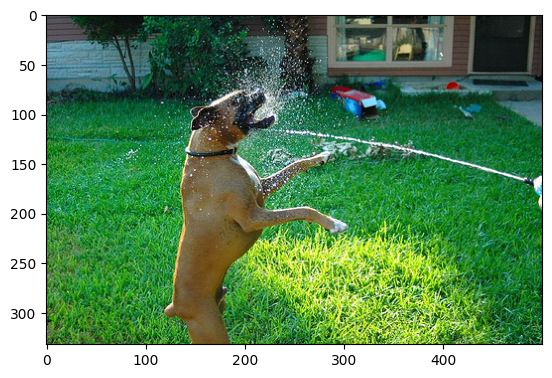

In [ ]:
imshow(examples['images'][2])

In [ ]:
print("Ground truth caption: ", examples['captions'][2])
print("Generated caption: ", tokenizer.decode(generated_text[0]).split('>')[-1])

Ground truth caption:  A brown dog is sprayed with water .
Generated caption:  An image of ǂǂǂǂǂǂǂǂǂǂ


### Two shot examples

In [ ]:
from PIL import Image
import requests

demo_image_one = Image.open(
    requests.get(
        "http://images.cocodataset.org/val2017/000000039769.jpg", stream=True
    ).raw
)

demo_image_two = Image.open(
    requests.get(
        "http://images.cocodataset.org/test-stuff2017/000000028137.jpg",
        stream=True
    ).raw
)

query_image = Image.open(
    requests.get(
        "http://images.cocodataset.org/test-stuff2017/000000028352.jpg",
        stream=True
    ).raw
)

vision_x = [image_processor(demo_image_one).unsqueeze(0), image_processor(demo_image_two).unsqueeze(0), image_processor(query_image).unsqueeze(0)]
vision_x = torch.cat(vision_x, dim=0)
vision_x = vision_x.unsqueeze(1).unsqueeze(0)


tokenizer.padding_side = "left" # For generation padding tokens should be on the left
lang_x = tokenizer(
    ["<image>An image of two cats.<|endofchunk|><image>An image of a bathroom sink.<|endofchunk|><image>An image of"],
    return_tensors="pt",
)


generated_text = model.generate(
    vision_x=vision_x,
    lang_x=lang_x["input_ids"],
    attention_mask=lang_x["attention_mask"],
    max_new_tokens=20,
    num_beams=3,
)

print("Generated text: ", tokenizer.decode(generated_text[0]).split('>')[-1])


Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


Generated text:  <image>An image of two cats.<|endofchunk|><image>An image of a bathroom sink.<|endofchunk|><image>An image of a bathroom sink. Isn’t a bathroom sink a bathroom sink a bathroom sink a bathroom sink a


Generated caption: An image of a bathroom sink. Isn’t a bathroom sink a bathroom sink a bathroom sink a bathroom sink a


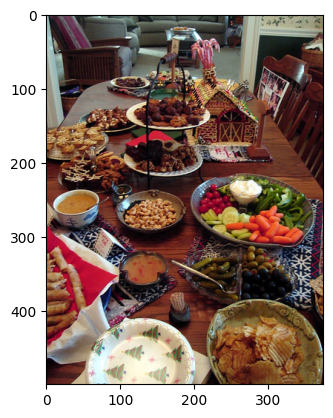

In [ ]:
imshow(query_image)
print("Generated caption: ", tokenizer.decode(generated_text[0]).split('>')[-1])

Insight: We see an example where the model repeats the description of the previous example. This was not mentioned in the paper but could give hints as to improving the model performance